## Exponentially Weighted Covariance / EWMA

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# === Path and ticker mapping ===
predicted_data_folder = r"Pred_Data"

ticker_to_basename = {
    "^NSEI": "NIFTY_50",
    "^NSEBANK": "NIFTY_BANK",
    "^CNXIT": "NIFTY_IT",
    "^CNXPHARMA": "NIFTY_PHARMA",
    "^CNXFMCG": "NIFTY_FMCG",
    "^CNXAUTO": "NIFTY_AUTO",
    "^CNXMETAL": "NIFTY_METAL",
    "^CNXREALTY": "NIFTY_REALTY",
    "^CNXENERGY": "NIFTY_ENERGY",
    "NIFTY_FIN_SERVICE.NS": "NIFTY_FIN_SERVICE",
    "RELIANCE.NS": "RELIANCE_INDUSTRIES_LTD",
    "TCS.NS": "TATA_CONSULTANCY_SERV_LT",
    "SUNPHARMA.NS": "SUN_PHARMACEUTICAL_IND_L",
    "ICICIBANK.NS": "ICICI_BANK_LTD.",
    "INFY.NS": "INFOSYS_LIMITED",
    "SBIN.NS": "STATE_BANK_OF_INDIA",
    "BHARTIARTL.NS": "BHARTI_AIRTEL_LIMITED",
    "ITC.NS": "ITC_LTD",
    "LT.NS": "LARSEN_&_TOUBRO_LTD.",
    "HINDUNILVR.NS": "HINDUSTAN_UNILEVER_LTD."
}

In [3]:
def simulate_investment(df, amt, start_date, end_date, plot=False):
    df = df.copy()

    if 'Datetime' in df.index.names:
        df = df.reset_index()

    if 'Datetime' not in df.columns:
        raise ValueError("No 'Datetime' column found after reset_index.")

    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").reset_index(drop=True)

    # ---- Filter to start/end range ----
    actual_start = df[df["Datetime"] >= pd.to_datetime(start_date)]
    if actual_start.empty:
        raise ValueError("No data after the given start_date")
    start_row = actual_start.iloc[0]

    actual_end = df[df["Datetime"] <= pd.to_datetime(end_date)]
    if actual_end.empty:
        raise ValueError("No data before the given end_date")
    end_row = actual_end.iloc[-1]

    df = df[(df["Datetime"] >= start_row["Datetime"]) & (df["Datetime"] <= end_row["Datetime"])].reset_index(drop=True)

    # ---- Compute predicted and actual returns ----
    df["pred_return"] = df["PredictedPrice"].pct_change()
    df["actual_return"] = df["ActualPrice"].pct_change()

    invested = False
    cash = amt
    values = [cash]  # track value over time

    for i in range(1, len(df)):
        signal = df.loc[i, "pred_return"]
        actual_r = df.loc[i, "actual_return"]

        # If model predicts profit
        if signal > 0:
            if not invested:
                invested = True
            cash *= (1 + actual_r)
        else:
            if invested:
                invested = False
        values.append(cash)

    df["InvestmentValue"] = values

    final_value = df["InvestmentValue"].iloc[-1]
    profit_pct = ((final_value - amt) / amt) * 100

    summary = {
        "Initial Date Given": start_date,
        "Actual date of investment": str(start_row["Datetime"].date()),
        "Final Date Given": end_date,
        "Actual date of withdraw": str(end_row["Datetime"].date()),
        "Initial Amount": amt,
        "Final Amount": round(final_value, 2),
        "Return (%)": round(profit_pct, 2)
    }

    return summary


In [4]:
actual_returns = {}
expected_returns = {}

start_date = "2025-10-01"
end_date = "2025-11-06"

for ticker, basename in ticker_to_basename.items():
    file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ Missing: {basename}")
        continue

    df = pd.read_csv(file_path, parse_dates=["Datetime"])
    df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

    if len(df) <= 300:
        print(f"⚠️ Skipping {basename} — insufficient valid rows.")
        continue
    df = df.iloc[300:].copy()

    df["Actual_Return"] = df["ActualPrice"].pct_change()
    actual_returns[basename] = df.set_index("Datetime")["Actual_Return"].dropna()

    # Expected return via simulation
    try:
        sim = simulate_investment(df, amt=100000, start_date=start_date, end_date=end_date, plot=False)
        exp_ret = sim["Return (%)"] / 100.0
        expected_returns[basename] = exp_ret
        print(f"{basename}: Expected Return {exp_ret:.3f}")
    except Exception as e:
        print(f"Simulation failed for {basename}: {e}")

# Convert to DataFrames
actual_df = pd.concat(actual_returns, axis=1).dropna()
cov_matrix = actual_df.cov()
expected_return_series = pd.Series(expected_returns)


NIFTY_50: Expected Return 0.038
NIFTY_BANK: Expected Return 0.041
NIFTY_IT: Expected Return 0.057
NIFTY_PHARMA: Expected Return 0.018
NIFTY_FMCG: Expected Return 0.078
NIFTY_AUTO: Expected Return 0.008
NIFTY_METAL: Expected Return 0.051
NIFTY_REALTY: Expected Return 0.045
NIFTY_ENERGY: Expected Return 0.037
NIFTY_FIN_SERVICE: Expected Return 0.046
RELIANCE_INDUSTRIES_LTD: Expected Return 0.067
TATA_CONSULTANCY_SERV_LT: Expected Return 0.027
HDFC_BANK_LTD: Expected Return -0.003
ICICI_BANK_LTD.: Expected Return -0.002
INFOSYS_LIMITED: Expected Return 0.076
STATE_BANK_OF_INDIA: Expected Return 0.082
BHARTI_AIRTEL_LIMITED: Expected Return 0.092
ITC_LTD: Expected Return 0.064
LARSEN_&_TOUBRO_LTD.: Expected Return -0.002
HINDUSTAN_UNILEVER_LTD.: Expected Return 0.036


In [5]:
print("\nCovariance Matrix (from Actual Prices):")
cov_matrix.round(6)


Covariance Matrix (from Actual Prices):


,NIFTY_50,NIFTY_BANK,NIFTY_IT,NIFTY_PHARMA,NIFTY_FMCG,NIFTY_AUTO,NIFTY_METAL,NIFTY_REALTY,NIFTY_ENERGY,NIFTY_FIN_SERVICE,RELIANCE_INDUSTRIES_LTD,TATA_CONSULTANCY_SERV_LT,HDFC_BANK_LTD,ICICI_BANK_LTD.,INFOSYS_LIMITED,STATE_BANK_OF_INDIA,BHARTI_AIRTEL_LIMITED,ITC_LTD,LARSEN_&_TOUBRO_LTD.,HINDUSTAN_UNILEVER_LTD.
NIFTY_50,0.000009,0.000009,0.000009,0.000006,0.000005,0.000010,0.000012,0.000011,0.000011,0.000009,0.000010,0.000007,0.000007,0.000009,0.000009,0.000011,0.000008,0.000006,0.000011,0.000004
NIFTY_BANK,0.000009,0.000012,0.000006,0.000005,0.000004,0.000009,0.000011,0.000012,0.000011,0.000012,0.000009,0.000005,0.000011,0.000012,0.000006,0.000014,0.000007,0.000004,0.000010,0.000002
NIFTY_IT,0.000009,0.000006,0.000023,0.000006,0.000005,0.000009,0.000011,0.000009,0.000009,0.000007,0.000008,0.000019,0.000003,0.000006,0.000024,0.000007,0.000007,0.000005,0.000009,0.000003
NIFTY_PHARMA,0.000006,0.000005,0.000006,0.000014,0.000004,0.000008,0.000011,0.000009,0.000009,0.000005,0.000007,0.000004,0.000003,0.000004,0.000005,0.000006,0.000005,0.000003,0.000008,0.000003
NIFTY_FMCG,0.000005,0.000004,0.000005,0.000004,0.000011,0.000006,0.000005,0.000005,0.000005,0.000004,0.000006,0.000004,0.000003,0.000003,0.000005,0.000004,0.000004,0.000011,0.000004,0.000012
NIFTY_AUTO,0.000010,0.000009,0.000009,0.000008,0.000006,0.000020,0.000016,0.000015,0.000014,0.000009,0.000011,0.000007,0.000005,0.000008,0.000008,0.000011,0.000009,0.000005,0.000012,0.000005
NIFTY_METAL,0.000012,0.000011,0.000011,0.000011,0.000005,0.000016,0.000031,0.000020,0.000021,0.000011,0.000014,0.000007,0.000007,0.000009,0.000010,0.000017,0.000009,0.000005,0.000017,0.000002
NIFTY_REALTY,0.000011,0.000012,0.000009,0.000009,0.000005,0.000015,0.000020,0.000038,0.000019,0.000012,0.000013,0.000006,0.000010,0.000010,0.000007,0.000016,0.000009,0.000005,0.000017,0.000002
NIFTY_ENERGY,0.000011,0.000011,0.000009,0.000009,0.000005,0.000014,0.000021,0.000019,0.000023,0.000011,0.000016,0.000006,0.000006,0.000009,0.000007,0.000017,0.000008,0.000005,0.000018,0.000002
NIFTY_FIN_SERVICE,0.000009,0.000012,0.000007,0.000005,0.000004,0.000009,0.000011,0.000012,0.000011,0.000012,0.000009,0.000005,0.000012,0.000012,0.000006,0.000013,0.000007,0.000004,0.000010,0.000002


In [6]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def optimize_intraday_portfolio_ewma(predicted_data_folder, ticker_to_basename,
                                     simulate_investment, start_date, end_date,
                                     rf=0.0, span=20):
    """
    Optimize intraday portfolio using EWMA (Exponential Weighted Moving Average) covariance.
    """
    actual_returns = {}
    expected_returns = {}

    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

        if len(df) <= 300:
            continue

        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df = df.set_index("Datetime")

        df = df.loc[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]
        if df.empty:
            continue

        actual_returns[basename] = df["Actual_Return"].dropna()

        try:
            sim = simulate_investment(df, amt=100000, start_date=start_date, end_date=end_date, plot=False)
            expected_returns[basename] = sim["Return (%)"] / 100.0
        except Exception:
            continue

    if not actual_returns:
        raise ValueError("No valid data found in date range")

    actual_df = pd.concat(actual_returns, axis=1).dropna()
    expected_ret = pd.Series(expected_returns)

    # --- EWMA Covariance Matrix ---
    cov_matrix = actual_df.ewm(span=span).cov(pairwise=True).iloc[-len(actual_df.columns):]

    n = len(expected_ret)
    mean_returns = expected_ret.values

    def portfolio_performance(weights):
        ret = np.dot(weights, mean_returns)
        vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
        sharpe = (ret - rf) / vol if vol > 0 else 0
        return ret, vol, sharpe

    def neg_sharpe(weights):
        _, _, sharpe = portfolio_performance(weights)
        return -sharpe

    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    init_guess = np.ones(n) / n

    opt_result = minimize(neg_sharpe, init_guess, bounds=bounds, constraints=constraints)
    best_weights = opt_result.x
    ret, vol, sharpe = portfolio_performance(best_weights)

    result = pd.DataFrame({
        "Asset": expected_ret.index,
        "Weight": best_weights,
        "Expected_Return": expected_ret.values
    }).sort_values(by="Weight", ascending=False)

    # === Formatted Display ===
    result["Weight"] = result["Weight"].map(lambda x: f"{x:.8f}")
    result["Expected_Return"] = result["Expected_Return"].map(lambda x: f"{x:.4f}")

    print("\n=== Optimal Intraday Portfolio (EWMA) ===")
    print(result.to_string(index=False))
    print(f"\nPortfolio Expected Return: {ret:.4f}")
    print(f"Portfolio Volatility: {vol:.4f}")
    print(f"Sharpe Ratio: {sharpe:.4f}")

    return result, cov_matrix, {"Return": ret, "Volatility": vol, "Sharpe": sharpe}


In [7]:
def eff_front_simulation_ewma(predicted_data_folder, ticker_to_basename,
                              simulate_investment, apply_date, withdraw_date,
                              k=3, rf=0.0, span=20):
    """
    Rolling hourly optimization using EWMA covariance and past k days of data.
    Returns total return, invest/withdraw dates, avg risk, and weights dataframe.
    """
    all_returns = {}

    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

        if len(df) <= 300:
            continue

        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df = df.set_index("Datetime")

        start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
        mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
        df = df.loc[mask]
        if df.empty:
            continue

        all_returns[basename] = df["Actual_Return"].dropna()

    if not all_returns:
        raise ValueError("No valid assets with data between given dates")

    actual_df = pd.concat(all_returns, axis=1).dropna()
    time_points = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) & 
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()

    weights_history = pd.DataFrame(index=time_points, columns=list(all_returns.keys()), dtype=float)
    results = []
    port_returns = []

    for current_time in time_points:
        window_start = current_time - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]
        if len(window_df) < 10:
            continue

        cov_matrix = window_df.ewm(span=span).cov(pairwise=True).iloc[-len(window_df.columns):]
        mean_returns = window_df.mean().values
        n = len(mean_returns)

        def performance(w):
            ret = np.dot(w, mean_returns)
            vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))
            sharpe = (ret - rf) / vol if vol > 0 else 0
            return ret, vol, sharpe

        def neg_sharpe(w):
            _, _, sharpe = performance(w)
            return -sharpe

        cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
        bounds = tuple((0, 1) for _ in range(n))
        w0 = np.ones(n) / n

        opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
        opt_w = opt.x

        weights_history.loc[current_time, :] = opt_w
        ret, vol, sharpe = performance(opt_w)
        results.append((current_time, ret, vol, sharpe))

        if current_time in actual_df.index:
            port_returns.append(np.dot(opt_w, actual_df.loc[current_time].values))

    weights_history = weights_history.dropna(how="all")
    port_returns = np.array(port_returns)

    total_return = np.prod(1 + port_returns) - 1
    avg_risk = np.mean([r[2] for r in results if not np.isnan(r[2])])

    summary = {
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": k,
        "EWMA_Span": span,
        "Total_Return": float(total_return),
        "Average_Risk": float(avg_risk)
    }

    print("\n=== Rolling EWMA Efficient Frontier Simulation ===")
    print(f"Investment Period: {apply_date} → {withdraw_date}")
    print(f"Lookback Window: {k} days | EWMA Span: {span}")
    print(f"Total Return: {total_return:.4%}")
    print(f"Average Risk (Volatility): {avg_risk:.6f}")
    print(f"Total Optimization Points: {len(results)}")

    return summary, weights_history


In [8]:
# Single-period optimization (EWMA)
res_ewma, cov_ewma, stats_ewma = optimize_intraday_portfolio_ewma(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    simulate_investment=simulate_investment,
    start_date="2025-10-01",
    end_date="2025-11-06",
    rf=0.05 / 252,
    span=24  # roughly 1-day EWMA for hourly data
)


=== Optimal Intraday Portfolio (EWMA) ===
                   Asset     Weight Expected_Return
              NIFTY_FMCG 0.32859246          0.0781
 RELIANCE_INDUSTRIES_LTD 0.22128816          0.0674
         INFOSYS_LIMITED 0.14171759          0.0756
   BHARTI_AIRTEL_LIMITED 0.13185161          0.0918
     STATE_BANK_OF_INDIA 0.06515839          0.0819
    LARSEN_&_TOUBRO_LTD. 0.05612114         -0.0021
       NIFTY_FIN_SERVICE 0.05527065          0.0459
             NIFTY_METAL 0.00000000          0.0513
            NIFTY_ENERGY 0.00000000          0.0371
                NIFTY_IT 0.00000000          0.0566
              NIFTY_BANK 0.00000000          0.0412
TATA_CONSULTANCY_SERV_LT 0.00000000          0.0273
 HINDUSTAN_UNILEVER_LTD. 0.00000000          0.0363
         ICICI_BANK_LTD. 0.00000000         -0.0024
           HDFC_BANK_LTD 0.00000000         -0.0026
            NIFTY_REALTY 0.00000000          0.0452
              NIFTY_AUTO 0.00000000          0.0082
                 ITC_

In [9]:
# Rolling hourly simulation (EWMA)
summary_ewma, weights_df_ewma = eff_front_simulation_ewma(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    simulate_investment=simulate_investment,
    apply_date="2025-10-01",
    withdraw_date="2025-10-20",
    k=10,
    rf=0.05 / 252,
    span=24
)


=== Rolling EWMA Efficient Frontier Simulation ===
Investment Period: 2025-10-01 → 2025-10-20
Lookback Window: 10 days | EWMA Span: 24
Total Return: 8.5092%
Average Risk (Volatility): 0.002110
Total Optimization Points: 84


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def eff_front_simulation_ewma(predicted_data_folder, ticker_to_basename,
                              simulate_investment, apply_date, withdraw_date,
                              k=3, rf=0.0, span=20):
    """
    Rolling hourly optimization using EWMA covariance and past k days of data.
    Returns summary, weights dataframe, and return_df (Datetime + Realized_Portfolio_Value).
    """
    all_returns = {}

    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

        if len(df) <= 300:
            continue

        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df = df.set_index("Datetime")

        start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
        mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
        df = df.loc[mask]
        if df.empty:
            continue

        all_returns[basename] = df["Actual_Return"].dropna()

    if not all_returns:
        raise ValueError("No valid assets with data between given dates")

    actual_df = pd.concat(all_returns, axis=1).dropna()
    time_points = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) & 
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()

    weights_history = pd.DataFrame(index=time_points, columns=list(all_returns.keys()), dtype=float)
    results = []
    port_returns = []
    realized_times = []

    for current_time in time_points:
        window_start = current_time - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]
        if len(window_df) < 10:
            continue

        # EWMA covariance: compute pairwise EWMA cov on the window and take the final block
        # (we keep your original style of computing EWMA cov)
        cov_ewma = window_df.ewm(span=span).cov(pairwise=True)
        # extract last covariance matrix for the most recent timestamp in the ewm result
        # cov_ewma has MultiIndex (Datetime, column) x column, so select last timestamp block
        last_ts = cov_ewma.index.get_level_values(0)[-1]
        cov_matrix = cov_ewma.loc[last_ts].reindex(index=window_df.columns, columns=window_df.columns).fillna(0)

        mean_returns = window_df.mean().values
        n = len(mean_returns)

        def performance(w):
            ret = np.dot(w, mean_returns)
            vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))
            sharpe = (ret - rf) / vol if vol > 0 else 0
            return ret, vol, sharpe

        def neg_sharpe(w):
            _, _, sharpe = performance(w)
            return -sharpe

        cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
        bounds = tuple((0, 1) for _ in range(n))
        w0 = np.ones(n) / n

        opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
        opt_w = opt.x

        weights_history.loc[current_time, :] = opt_w
        ret, vol, sharpe = performance(opt_w)
        results.append((current_time, ret, vol, sharpe))

        if current_time in actual_df.index:
            port_returns.append(np.dot(opt_w, actual_df.loc[current_time].values))
            realized_times.append(current_time)

    weights_history = weights_history.dropna(how="all")
    port_returns = np.array(port_returns)

    total_return = np.prod(1 + port_returns) - 1
    avg_risk = np.mean([r[2] for r in results if not np.isnan(r[2])]) if results else 0.0

    # -----------------------------
    # Compute VaR (Parametric & Historical) from realized portfolio returns
    # -----------------------------
    confidence_level = 0.95
    z_score = 1.65  # approx for 95%

    if len(port_returns) > 0:
        mu_p = np.mean(port_returns)
        sigma_p = np.std(port_returns)

        var_parametric = -(mu_p - z_score * sigma_p)
        var_historical = -np.percentile(port_returns, (1 - confidence_level) * 100)
    else:
        var_parametric = np.nan
        var_historical = np.nan

    # -----------------------------
    # Create return_df for Realized Portfolio Value (₹100 base)
    # -----------------------------
    if len(port_returns) > 0:
        realized_series = pd.Series(port_returns, index=pd.DatetimeIndex(realized_times))
        realized_value = 100 * (1 + realized_series).cumprod()
        return_df = pd.DataFrame({
            "Datetime": realized_value.index,
            "Realized_Portfolio_Value": realized_value.values
        }).reset_index(drop=True)
    else:
        return_df = pd.DataFrame({
            "Datetime": [],
            "Realized_Portfolio_Value": []
        })

    summary = {
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": k,
        "EWMA_Span": span,
        "Total_Return": float(total_return),
        "Average_Risk": float(avg_risk),
        "Parametric_VaR": float(var_parametric) if not np.isnan(var_parametric) else None,
        "Historical_VaR": float(var_historical) if not np.isnan(var_historical) else None,
        "Confidence_Level": confidence_level
    }

    # -----------------------------
    # Console Output
    # -----------------------------
    print("\n=== Rolling EWMA Efficient Frontier Simulation ===")
    print(f"Investment Period: {apply_date} → {withdraw_date}")
    print(f"Lookback Window: {k} days | EWMA Span: {span}")
    print(f"Total Return: {total_return:.4%}")
    print(f"Average Risk (Volatility): {avg_risk:.6f}")
    if not np.isnan(var_parametric):
        print(f"Parametric VaR (95%): {var_parametric:.4%}")
        print(f"Historical VaR (95%): {var_historical:.4%}")
    print(f"Total Optimization Points: {len(results)}")

    # -----------------------------
    # Plot Realized Portfolio Growth (if available)
    # -----------------------------
    if not return_df.empty:
        plt.figure(figsize=(10, 5))
        plt.plot(return_df["Datetime"], return_df["Realized_Portfolio_Value"], color='royalblue', lw=2)
        plt.title("EWMA HRP Realized Portfolio — ₹100 Investment Growth", fontsize=13)
        plt.xlabel("Datetime")
        plt.ylabel("Portfolio Value (₹)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        # Annotate final value
        final_val = return_df["Realized_Portfolio_Value"].iloc[-1]
        plt.text(return_df["Datetime"].iloc[-1], final_val, f" ₹{final_val:.2f}", fontsize=10,
                 color='black', ha='left', va='center')
        plt.show()

    return summary, weights_history, return_df



=== Rolling EWMA Efficient Frontier Simulation ===
Investment Period: 2025-10-01 → 2025-10-20
Lookback Window: 10 days | EWMA Span: 24
Total Return: 8.5092%
Average Risk (Volatility): 0.002110
Parametric VaR (95%): 0.3151%
Historical VaR (95%): 0.2314%
Total Optimization Points: 84


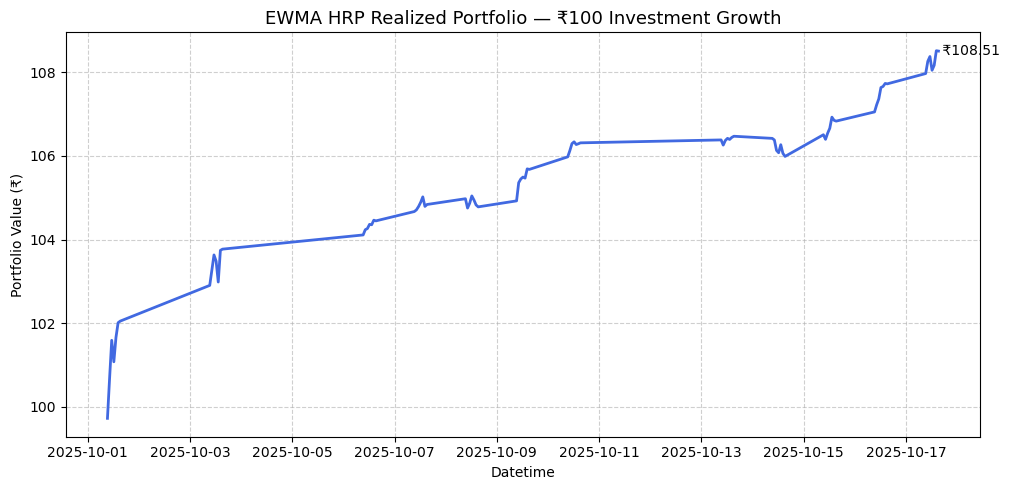

In [11]:
# Rolling hourly simulation (EWMA)
summary_ewma, weights_df_ewma, result_df = eff_front_simulation_ewma(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    simulate_investment=simulate_investment,
    apply_date="2025-10-01",
    withdraw_date="2025-10-20",
    k=10,
    rf=0.05 / 252,
    span=24
)

In [12]:
result_df

,Datetime,Realized_Portfolio_Value
0,2025-10-01 09:15:00,99.725303
1,2025-10-01 10:15:00,100.679409
2,2025-10-01 11:15:00,101.591580
3,2025-10-01 12:15:00,101.077827
4,2025-10-01 13:15:00,101.661595
...,...,...
79,2025-10-17 11:15:00,108.378399
80,2025-10-17 12:15:00,108.050421
81,2025-10-17 13:15:00,108.168984
82,2025-10-17 14:15:00,108.517818
